In [1]:
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F


In [2]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Anand\mypy\Lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [26]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        #equation 8 matrices
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cpu()
        
        #initiale hidden states
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cpu()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cpu()
        
        for t in range(self.T):
            #concatenate hidden states
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            #attention weights for each k in N (equation 8)
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            #normalize attention weights (equation 9)
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            #weight inputs (equation 10)
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            #calculate next hidden states (equation 11)
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [27]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        #equation 12 matrices
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        #equation 15 matrix
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        #equation 22 matrices
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        #initializing hidden states
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cpu()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cpu()
        for t in range(self.T):
            #concatenate hidden states
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            #print(d_s_prime_concat)
            #temporal attention weights (equation 12)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            #normalized attention weights (equation 13)
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            #create context vector (equation_14)
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            #concatenate c_t and y_t
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)
            #create y_tilda
            y_tilda_t = self.w_tilda(y_c_concat)
            
            #calculate next hidden states (equation 16)
            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        #concatenate context vector at step T and hidden state at step T
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        #calculate output
        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [29]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cpu()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cpu()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [89]:
TS = pd.read_csv("bigmat_mn_60s.csv", parse_dates=['T'])

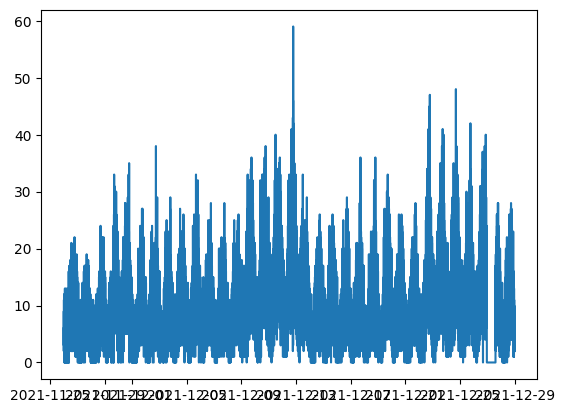

In [35]:
plt.plot(TS['T'],TS['Tbig_hist'])

In [142]:
TSn=TS.copy()
TSn=TSn.iloc[:,1:].rolling(10,center=True,min_periods=2).mean()
TSn['T']=TS['T']
TSn['S1A']=0.5*(TSn['CO_244_IE']+TSn['CO_456_IE'])
TSn['S2A']=0.5*(TSn['CO_234_TT']+TSn['CO_451_TT'])
TSn['Sdif']=TSn['S2A']-TSn['S1A']
TSn.loc[TSn['Sdif']==0,'Sdif']=np.nan
TSn.loc[TSn['Tbig_hist']==0,'Tbig_hist']=np.nan
TSn=TSn.loc[TSn['T'] < '2021-12-28 09:00:00',:]
ttmp=TSn.copy()
TSn.drop(list(TSn.filter(regex=("CO_*")).columns)+['T_hist','T_avgspd','AT', 'RH', 'WS', 'SR'],axis=1,inplace=True)
data=TSn.copy()
data['Day'] = data['T'].dt.day
data['Weekday'] = data['T'].dt.weekday  # Monday=0, Sunday=6
data['Hour'] = data['T'].dt.hour
data['Month'] = data['T'].dt.month
data.drop(columns=['S1A','S2A','T'],inplace=True)


In [141]:
data['T'][].weekday()

,Tbig_hist,Tbig_avgspd,T,Sdif,Day,Weekday,Hour,Month
0,4.600000,55.355667,2021-11-26 00:01:00,-0.004309,26,4,0,11
1,5.000000,56.128770,2021-11-26 00:02:00,-0.020210,26,4,0,11
2,4.714286,54.619660,2021-11-26 00:03:00,-0.027893,26,4,0,11
3,5.125000,53.728765,2021-11-26 00:04:00,-0.043441,26,4,0,11
4,4.888889,54.116402,2021-11-26 00:05:00,-0.053962,26,4,0,11
...,...,...,...,...,...,...,...,...
46614,8.700000,52.383786,2021-12-28 08:55:00,1.023536,28,1,8,12
46615,9.400000,51.815170,2021-12-28 08:56:00,1.163419,28,1,8,12
46616,9.600000,50.882959,2021-12-28 08:57:00,1.287500,28,1,8,12
46617,10.700000,49.164192,2021-12-28 08:58:00,1.316871,28,1,8,12


In [110]:
batch_size = 32
timesteps = 8
n_timeseries = data.shape[1] - 1
train_brdr = int(data.shape[0]*0.7)
val_brdr = int(data.shape[0]*0.85)
# test_brdr= int(data.shape[0]*0.85)
targetC = "Sdif"

In [111]:
device = torch.device('cpu')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')

In [112]:
X = np.zeros((len(data), timesteps, data.shape[1]-1))
y = np.zeros((len(data), timesteps, 1))

In [113]:
for i, name in enumerate(list(data.columns[:-1])):
    for j in range(timesteps):
        X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")

C:\Users\Anand\AppData\Local\Temp\ipykernel_15864\3678306337.py:3: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [114]:
for j in range(timesteps):
    y[:, j, 0] = data[targetC].shift(timesteps - j - 1).fillna(method="bfill")

C:\Users\Anand\AppData\Local\Temp\ipykernel_15864\1451580150.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [115]:
prediction_horizon = 15
target = data[targetC].shift(-prediction_horizon).fillna(method="ffill").values

C:\Users\Anand\AppData\Local\Temp\ipykernel_15864\3545059397.py:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [116]:
data

,Tbig_hist,Tbig_avgspd,T,Sdif
0,4.600000,55.355667,2021-11-26 00:01:00,-0.004309
1,5.000000,56.128770,2021-11-26 00:02:00,-0.020210
2,4.714286,54.619660,2021-11-26 00:03:00,-0.027893
3,5.125000,53.728765,2021-11-26 00:04:00,-0.043441
4,4.888889,54.116402,2021-11-26 00:05:00,-0.053962
...,...,...,...,...
46614,8.700000,52.383786,2021-12-28 08:55:00,1.023536
46615,9.400000,51.815170,2021-12-28 08:56:00,1.163419
46616,9.600000,50.882959,2021-12-28 08:57:00,1.287500
46617,10.700000,49.164192,2021-12-28 08:58:00,1.316871


In [117]:
X = X[timesteps:]
y = y[timesteps:]
target = target[timesteps:]

In [118]:
X.shape,y.shape,target.shape

((46611, 8, 3), (46611, 8, 1), (46611,))

In [119]:
X_train = X[:train_brdr]
y_his_train = y[:train_brdr]
X_val = X[train_brdr:val_brdr]
y_his_val = y[train_brdr:val_brdr]
X_test = X[val_brdr:]
y_his_test = y[val_brdr:]
target_train = target[:train_brdr]
target_val = target[train_brdr:val_brdr]
target_test = target[val_brdr:]

In [120]:
X_train_max = X_train.max(axis=0)
X_train_min = X_train.min(axis=0)
y_his_train_max = y_his_train.max(axis=0)
y_his_train_min = y_his_train.min(axis=0)
target_train_max = target_train.max(axis=0)
target_train_min = target_train.min(axis=0)

In [121]:
X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
X_val = (X_val - X_train_min) / (X_train_max - X_train_min)
X_test = (X_test - X_train_min) / (X_train_max - X_train_min)

y_his_train = (y_his_train - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_val = (y_his_val - y_his_train_min) / (y_his_train_max - y_his_train_min)
y_his_test = (y_his_test - y_his_train_min) / (y_his_train_max - y_his_train_min)

target_train = (target_train - target_train_min) / (target_train_max - target_train_min)
target_val = (target_val - target_train_min) / (target_train_max - target_train_min)
target_test = (target_test - target_train_min) / (target_train_max - target_train_min)

### DARNN

In [48]:
X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)
y_his_train_t = torch.Tensor(y_his_train)
y_his_val_t = torch.Tensor(y_his_val)
y_his_test_t = torch.Tensor(y_his_test)
target_train_t = torch.Tensor(target_train)
target_val_t = torch.Tensor(target_val)
target_test_t = torch.Tensor(target_test)

In [49]:
model = DARNN(X_train.shape[2], 64, 64, X_train.shape[1]).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [50]:
epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

In [51]:
from torch.utils.data import TensorDataset, DataLoader
data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=32)
data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=32)
data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=32)

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [53]:
epochs = 150
loss = nn.MSELoss()
patience = 15
min_val_loss = 9999
counter = 0
for i in range(epochs):
    mse_train = 0
    for batch_x, batch_y_h, batch_y in data_train_loader :
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.cpu()
        opt.zero_grad()
        y_pred = model(batch_x, batch_y_h)
        y_pred = y_pred.squeeze(1)
        l = loss(y_pred, batch_y)
        l.backward()
        mse_train += l.item()*batch_x.shape[0]
        opt.step()
    epoch_scheduler.step()
    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_val_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            batch_y_h = batch_y_h.cpu()
            output = model(batch_x, batch_y_h)
            output = output.squeeze(1)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
    
    if min_val_loss > mse_val**0.5:
        min_val_loss = mse_val**0.5
        print("Saving...")
        torch.save(model.state_dict(), "iith.pt")
        counter = 0
    else: 
        counter += 1
    
    if counter == patience:
        break
    print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
#     if(i % 10 == 0):
#         preds = preds*(target_train_max - target_train_min) + target_train_min
#         true = true*(target_train_max - target_train_min) + target_train_min
#         mse = mean_squared_error(true, preds)
#         mae = mean_absolute_error(true, preds)
#         print("mse: ", mse, "mae: ", mae)
#         plt.figure(figsize=(20, 10))
#         plt.plot(preds)
#         plt.plot(true)
#         plt.show()

Saving...
Iter:  0 train:  0.0945464613543344 val:  0.07811073456369366
Saving...
Iter:  1 train:  0.07642685585278561 val:  0.07556147479425958
Saving...
Iter:  2 train:  0.0750769931410654 val:  0.07399395441187744
Iter:  3 train:  0.07410262801256491 val:  0.07470752346282857
Iter:  4 train:  0.07347896043703842 val:  0.07402124853528108
Saving...
Iter:  5 train:  0.07310154997246474 val:  0.07153317953923802
Iter:  6 train:  0.07257377239118702 val:  0.0744300775632653
Saving...
Iter:  7 train:  0.07252185953090558 val:  0.07099166966212157
Iter:  8 train:  0.07235427243590113 val:  0.07114326277449498
Iter:  9 train:  0.0722587830445071 val:  0.07130421872032322
Iter:  10 train:  0.07199808144660984 val:  0.0730724531218861
Iter:  11 train:  0.07192715020396888 val:  0.0712131580092707
Iter:  12 train:  0.0718509328323747 val:  0.07127201837881883
Iter:  13 train:  0.07165235903724235 val:  0.071765740724062
Iter:  14 train:  0.0716193411699635 val:  0.07150203308012963
Iter:  15 

In [143]:
model.load_state_dict(torch.load("iith.pt"))

C:\Users\Anand\AppData\Local\Temp\ipykernel_15864\3456456852.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



RuntimeError: Error(s) in loading state_dict for DARNN:
	size mismatch for encoder.encoder_lstm.weight_ih: copying a param with shape torch.Size([256, 6]) from checkpoint, the shape in current model is torch.Size([256, 5]).

In [144]:
with torch.no_grad():
    mse_val = 0
    preds = []
    true = []
    for batch_x, batch_y_h, batch_y in data_test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_h = batch_y_h.to(device)
        output = model(batch_x, batch_y_h)
        preds.append(output.detach().cpu().numpy())
        true.append(batch_y.detach().cpu().numpy())
        mse_val += loss(output, batch_y).item()*batch_x.shape[0]
preds = np.concatenate(preds)
true = np.concatenate(true)

C:\Users\Anand\mypy\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

C:\Users\Anand\mypy\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning:

Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



In [145]:
preds = preds*(target_train_max - target_train_min) + target_train_min
true = true*(target_train_max - target_train_min) + target_train_min

In [58]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import joblib
(preds,true)=joblib.load('vfr_delS_10T')
fre=[(x,y[0]) for x,y in zip(true,preds) if not np.isnan(y)]
mt=np.vstack(np.array(fre))
mse = mean_squared_error(mt[0], mt[1])
mae = mean_absolute_error(mt[0], mt[1])
mape = mean_absolute_percentage_error(mt[0], mt[1])
r2_score = r2_score(mt[0], mt[1])
mse, mae, mape,r2_score

(0.001391594, 0.03182298, 0.030563198, 0.992841899394989)

In [36]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import joblib
(preds,true)=joblib.load('vfr_s2_15T')
fre=[(x,y[0]) for x,y in zip(true,preds) if not np.isnan(y)]
mt=np.vstack(np.array(fre))
mse = mean_squared_error(mt[0], mt[1])
mae = mean_absolute_error(mt[0], mt[1])
mape = mean_absolute_percentage_error(mt[0], mt[1])
r2_score = r2_score(mt[0], mt[1])
mse, mae, mape,r2_score

(0.008844677, 0.08967495, 0.04451082, 0.8435532018641367)

In [10]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error,r2_score
import joblib
(preds,true)=joblib.load('vfr_s1_s2_15T')
fre=[(x,y[0]) for x,y in zip(true,preds) if not np.isnan(y)]
mt=np.vstack(np.array(fre))
mse = mean_squared_error(mt[0], mt[1])
mae = mean_absolute_error(mt[0], mt[1])
mape = mean_absolute_percentage_error(mt[0], mt[1])
r2_score = r2_score(mt[0], mt[1])
mse, mae, mape,r2_score

(0.008692389, 0.08840734, 0.043827724, 0.8494839035648841)

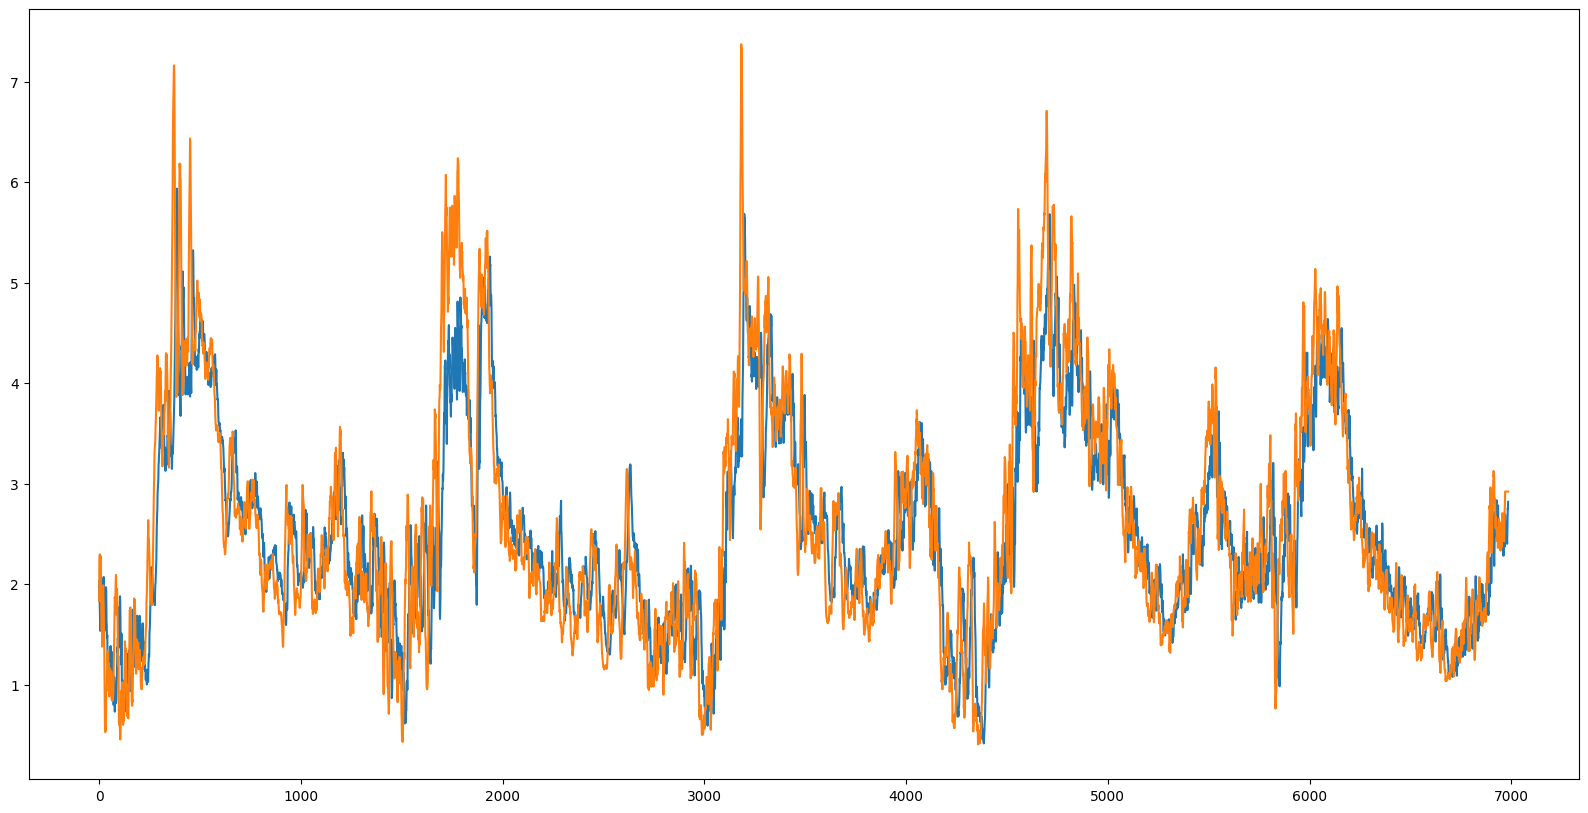

In [62]:
plt.figure(figsize=(20, 10))
plt.plot(preds)
plt.plot(true)
plt.show()

In [84]:
preds.squeeze().shape

(6985,)

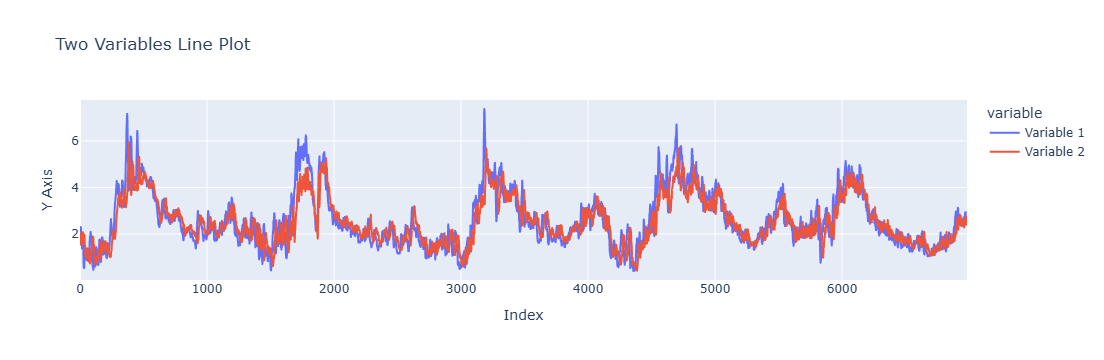

In [85]:
import pandas as pd
import plotly.express as px

# Sample data for two variables
data = {
    'Variable 1':true,
    'Variable 2': preds.squeeze()
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plot the data using plotly express
fig = px.line(df, labels={"value": "Y Axis", "index": "Index"}, title="Two Variables Line Plot")

# Show the plot
fig.show()


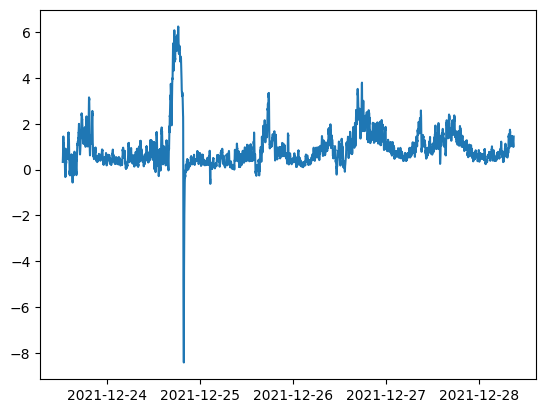

In [63]:
plt.plot(ttmp.loc[val_brdr+16:,'T'],ttmp.loc[val_brdr+16:,'Sdif'])

In [ ]:
(preds-true).T**2

In [ ]:
preds[true==np.nan]
# predscta=preds[]

In [27]:
ttmpct1=ttmpct.loc[ttmpct['T'].between('2021-12-27 00:00:00','2021-12-28 00:00:00')].copy()
ttmpct1

,Tbig_hist,Tbig_avgspd,T,S1A,S2A,True,pred
44639,NaN,NaN,2021-12-27 00:00:00,1.857078,3.000850,1.143772,1.002229
44640,NaN,NaN,2021-12-27 00:01:00,1.905656,2.933077,1.027421,0.868931
44641,NaN,NaN,2021-12-27 00:02:00,2.019318,2.958189,0.938871,0.745227
44642,NaN,NaN,2021-12-27 00:03:00,2.154981,3.109398,0.954417,0.805909
44643,NaN,NaN,2021-12-27 00:04:00,2.272495,3.338549,1.066054,1.032135
...,...,...,...,...,...,...,...
46075,8.0,54.353026,2021-12-27 23:56:00,1.266069,1.986931,0.720862,0.679942
46076,7.1,53.014390,2021-12-27 23:57:00,1.306315,2.090521,0.784206,0.751430
46077,7.4,53.450390,2021-12-27 23:58:00,1.317881,2.167457,0.849576,0.851261
46078,6.7,55.654240,2021-12-27 23:59:00,1.358948,2.211232,0.852283,0.854126


In [6]:
import joblib
import seaborn as sns

In [51]:
(preds,true)=joblib.load('vfr_delS_10T')
ttmp=data.copy()
ttmp=ttmp.rename({'Sdif':'True'},axis=1)
import plotly.express as px
ttmpct=ttmp.loc[val_brdr+16:].copy()
ttmpct.loc[:,'pred']=preds
ttmpct1=ttmpct.loc[ttmpct['T'].between('2021-12-27 00:00:00','2021-12-27 23:5:00')].copy()
fig=px.line(ttmpct1,x='T',y=['True','pred'])
fig.update_yaxes(title_text=r"$CO_{S2}-CO_{S1}$")
font_size = 16
fig.update_layout(
    font=dict(size=font_size),
    yaxis=dict(title_font=dict(size=font_size)),
    legend=dict(
        orientation="v",  # "h" for horizontal, "v" for vertical
        x=0.5,              # Adjust x position (0 to 1)
        y=1            # Adjust y position (smaller values move legend inside)
    ))
fig.update_xaxes(
    tickformat='%H',  # Display only the hour part
    type='date',      # Specify that x-axis values are datetime
    title='Time (hrs)'      # Set x-axis title
)



# fig.show()
import plotly.io as pio
pio.write_image(fig, 'truepred.png', format='png')

In [26]:
ttmp

,Tbig_hist,Tbig_avgspd,T,S1A,S2A,True
0,4.600000,55.355667,2021-11-26 00:01:00,3.653236,3.648927,-0.004309
1,5.000000,56.128770,2021-11-26 00:02:00,3.623098,3.602888,-0.020210
2,4.714286,54.619660,2021-11-26 00:03:00,3.594395,3.566502,-0.027893
3,5.125000,53.728765,2021-11-26 00:04:00,3.569427,3.525986,-0.043441
4,4.888889,54.116402,2021-11-26 00:05:00,3.543963,3.490001,-0.053962
...,...,...,...,...,...,...
46614,8.700000,52.383786,2021-12-28 08:55:00,1.468434,2.491970,1.023536
46615,9.400000,51.815170,2021-12-28 08:56:00,1.455961,2.619380,1.163419
46616,9.600000,50.882959,2021-12-28 08:57:00,1.470834,2.758333,1.287500
46617,10.700000,49.164192,2021-12-28 08:58:00,1.480165,2.797036,1.316871


In [45]:
ttmpct.loc[ttmpct['T'].between('2021-11-15 01:00:00','2021-12-20 23:50:00')]

,Tbig_hist,Tbig_avgspd,T,S1A,S2A,Sdif


In [42]:
# (preds,true)=joblib.load('vfr_delS_10T')
ttmp=data.copy()
# ttmp=ttmp.rename({'Sdif':'True'},axis=1)
import plotly.express as px
ttmpct=ttmp.loc[val_brdr+16:].copy()
# ttmpct.loc[:,'pred']=preds
ttmpct1=ttmpct.loc[ttmpct['T'].between('2021-12-19 01:00:00','2021-12-20 23:50:00')].copy()
fig=px.line(ttmpct1,x='T',y=['Tbig_hist','S2A'])
fig.update_yaxes(title_text=r"$CO_{S2}$")
font_size = 16
fig.update_layout(
    font=dict(size=font_size),
    yaxis=dict(title_font=dict(size=font_size)),
    legend=dict(
        orientation="h",  # "h" for horizontal, "v" for vertical
        x=0.5,              # Adjust x position (0 to 1)
        y=1            # Adjust y position (smaller values move legend inside)
    ))
fig.update_xaxes(
    tickformat='%H',  # Display only the hour part
    type='date',      # Specify that x-axis values are datetime
    title='Time (hrs)'      # Set x-axis title
)



fig.show()
# import plotly.io as pio
# pio.write_image(fig, 'truepred.png', format='png')

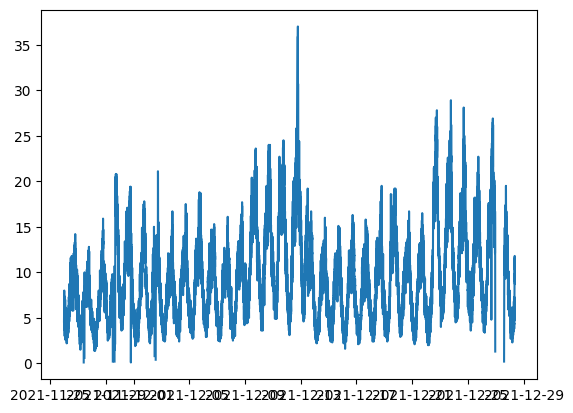

In [36]:
plt.plot(ttmp['T'],ttmp['Tbig_hist'])

In [ ]:
import joblib
(preds,true)=joblib.load('2var_15T')

In [ ]:
# sns.lineplot(data=ttmpct, x='T', y='True', label='True')
# sns.lineplot(data=ttmpct, x='T', y='pred', label='Pred')
# plt.xlabel('time')
# plt.ylabel(r"$\Delta CO$")
